# COGS 108 Final Project

## Group Members: 
- A14178715
- A11475687
- A12594395
- A11729103

### Introduction and Background:

What would it look like if we visualized a predicted sea level rise for the future? How accurate can we get based on a large dataset of the sea level rising over a long period of time?

Well, we should see a fairly accurate model of future sea level, represented by a map of the coastal regions of California flooded. This model will get less and less accurate the further we go into the future. To start, we need data. Here is a good one:

ftp://podaac.jpl.nasa.gov/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_V4_199209_201702.txt

ftp://podaac.jpl.nasa.gov/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_V4_199209_201703.txt (updated link, we downloaded the data from the first link while it still worked)

This is NASA's data on calculating the sea level increase with satellites. The link worked a while back, but no longer works, so we downloaded the data while it was available and have included it in our repository.


### Data Description:

NASA's description of the data:

"Global Mean Sea Level Data"
This file contains Global Mean Sea Level (GMSL) variations computed at the NASA Goddard Space Flight Center under the 
auspices of the NASA MEaSUREs program. The GMSL was generated using the Integrated Multi-Mission Ocean Altimeter Data for Climate Research (http://podaac.jpl.nasa.gov/dataset/MERGED_TP_J1_OSTM_OST_ALL_V4). It combines Sea Surface Heights from TOPEX/Poseidon, Jason-1, OSTM/Jason-2, and Jason-3 to a common terrestrial reference frame with all inter-mission biases, range and geophysical corrections applied and placed onto a georeferenced orbit. This creates a consistent data record throughout time, regardless of the instrument used."

### Starting out: imports

In [1]:
# imports
import csv
import itertools
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
%matplotlib inline
  

### Data Cleaning and Pre-processing

In [2]:
txtFile = "nasa_data_noheader.txt"
csvFile = "data.csv"
def processTxt(txtFile):
    with open(txtFile,'r') as in_file:
        # Our lines in nasa data have 1-4 spaces of separation so first we split the line
        stripped = (line.strip() for line in in_file)
        lines = (line.split(" ") for line in stripped if line)
        
        # Then here we write it to the csv and if there is an empty space it will replace it with nothing 
        with open(csvFile,'w') as out_file:
            # Column titles (adds empty row 2 we can just delete once its in pandas dataframe)
            writer = csv.writer(out_file)
            writer.writerow(('altimeter_type', 'file_cycle_#','date','obs_#','weighted_obs_#','mean_variation','std_dev_of_mean_var','smoothed_variation1','smoothed_variation2','std_dev_of_mean_var2','smoothed_variation3','smoothed_variation4', 'col12'))
            # for the above line, there are many extra and redundant forms of the data, such as GIA applied vs not applied. These columns are explained in the data.
            # four ur purposes, we only need a few of these columns, such as date, so the rest were not labelled in detail.
            for line in lines:
                for index in line:
                    # Replacing the white space with nothing
                    index.replace(" ", "") 
                    if index != "":
                        out_file.write(index + ",")
                out_file.write('\n')
processTxt(txtFile)


df = pd.read_csv('data.csv')
# remove the extra row (row2), drops only if all col = nan
df = df.dropna(how = 'all')

# hardcode way
# df = df.drop(df.index[1])
# only do this if you're absolutely sure the second row is all NaN. It looks fine to me in the original data file. 

# make a new dataframe without the columns we don't need
df2 = df[['date', 'mean_variation', 'smoothed_variation3']].copy()

# print the dataframe so we know we are on the right track
df2

# because the data point in every column of variation starts negative, we need to make them start at 0 for pretty plotting. 
# add 40.28 to every data point in the mean_variation column and 40.63 to every column in the smoothed_variation3 column
# this brings the floor of our data up to get it to look more like the plot on NASA's page: 
# https://climate.nasa.gov/vital-signs/sea-level/
df2['mean_variation'] += 40.28
df2['smoothed_variation3'] += 40.63

# lastly, change the dates to human readable dates that are easier to plot, like NASA did for their plot. 
# the dates are in fractions of years. There are many ways of converting them in python, just search "convert fractional years to real dates in python"

def human_date(date):
    days = (float(str(date-int(date))[1:]) * 365);
    return datetime.datetime(int(date), 1, 1) + datetime.timedelta(days - 1)

converted_dates = []

for index, row in df2.iterrows():
    converted_dates.append(human_date(row['date']))
    
df2 = df2.assign(human_readable = converted_dates)

### Data Visualization

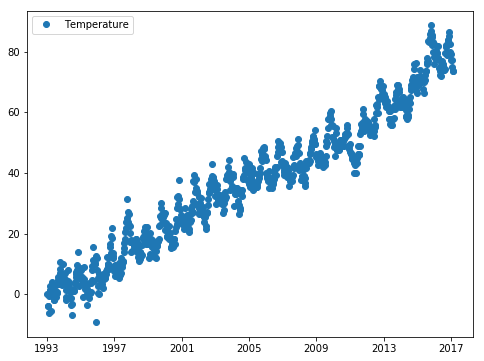

In [3]:
# plot data using plt.something()

fig, ax = plt.pyplot.subplots(figsize=(8,6))

ax.plot(df2['human_readable'], df2['mean_variation'], 'o', label="Temperature")
legend = ax.legend(loc="best")

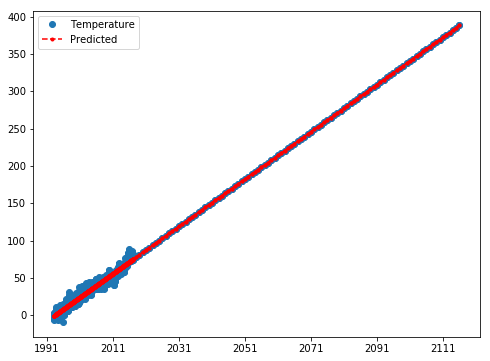

In [7]:
# predict future sea level rise for the next 100 years

smresults = smf.ols('mean_variation ~ date', df2).fit()

index = 888
for i in range(2017, 2117):
    prediction = smresults.predict(pd.DataFrame({'intercept': 1, 'date': [i]}))
    series = pd.Series([int(i),float(prediction),0,human_date(float(i))], 
                       index=['date', 'mean_variation', 'smoothed_variation3', 'human_readable'], name=str(index))
    df2 = df2.append(series)
    index += 1

fig, ax = plt.pyplot.subplots(figsize=(8,6))
outcome_1, predictors_1 = patsy.dmatrices('mean_variation ~ date', df2)
mod_1 = smf.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

ax.plot(df2['human_readable'], df2['mean_variation'], 'o', label="Temperature")
ax.plot(df2['human_readable'], res_1.fittedvalues, 'r--.', label="Predicted")
legend = ax.legend(loc="best")

In [5]:
# show what this prediction looks like in a google map

# todo

### Conclusions and Discussion:

the end